<a href="https://colab.research.google.com/github/FarahBouattour/knowWhatToEat/blob/main/Univariate_Ts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
print(tf.__version__)

2.5.0


In [2]:
# Window dataset, we're going to use it on x_train
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1) # This is required since we have specified a specific input function in the model
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

###univariate time series LSTM first try

In [3]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

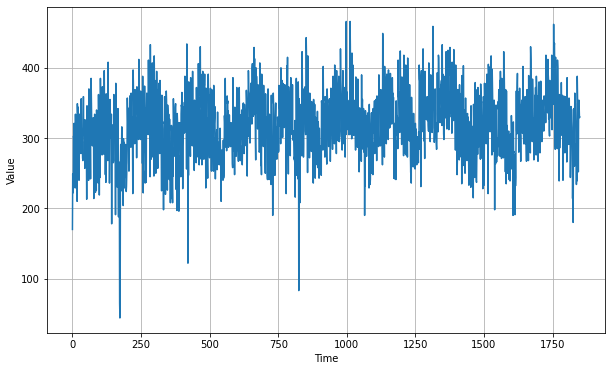

In [33]:
#df = pd.read_csv('reffined_data.csv')
df = pd.read_csv('data_pca_dt_covid_fi.csv')
df = df.iloc[:1850]
series = np.array(df['flux_journalier'])
#time_step = np.array(df['Date'])
time = np.array([i for i in range(len(df))]) 
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [34]:
series.shape
time.shape

(1850,)

In [11]:
series.dtype

dtype('int64')

In [38]:
m = max(series)
series = series / m 
split_time = 1250  #600
time_train = time[:split_time]
x_train = series[:split_time] 
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30 # 30 slices worth of data, so we're splitting the x_train 30 times !!!
batch_size = 32

print('total',series.shape)
print('train',x_train.shape)
print('test', x_valid.shape)

total (1850,)
train (1250,)
test (600,)


In [39]:
# We take the DNN model, and we try to apply it to our series use the window technique
# So after training it will help us forecast
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    # No map or shuffle, this was done in the windowed_dataset()
    forecast = model.predict(ds)
    return forecast

In [61]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

batch_size = 128
shuffle_buffer = 100
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer) # We take a window of x_train
print("train_set= ",train_set)
print("\n x_train.shape= ",x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=16, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]), # We have specified the input shape here so we need to change the windowed_dataset()
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(60, activation="relu"),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100)
])

# The whole purpose of this cell is to know which learning rate to use using the lr_schedule
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=20, callbacks=[lr_schedule])


train_set=  <PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>

 x_train.shape=  (1250,)
Epoch 1/20
10/10 [==============================] - 3s 49ms/step - loss: 2.0728 - mae: 2.5318
Epoch 2/20
10/10 [==============================] - 1s 51ms/step - loss: 1.1697 - mae: 1.6060
Epoch 3/20
10/10 [==============================] - 1s 52ms/step - loss: 0.5717 - mae: 0.9557
Epoch 4/20
10/10 [==============================] - 1s 51ms/step - loss: 0.3762 - mae: 0.7212
Epoch 5/20
10/10 [==============================] - 1s 52ms/step - loss: 0.2833 - mae: 0.6126
Epoch 6/20
10/10 [==============================] - 1s 52ms/step - loss: 0.2096 - mae: 0.5106
Epoch 7/20
10/10 [==============================] - 1s 54ms/step - loss: 0.1560 - mae: 0.4314
Epoch 8/20
10/10 [==============================] - 1s 54ms/step - loss: 0.1218 - mae: 0.3823
Epoch 9/20
10/10 [==============================] - 1s 52ms/step - loss: 0.0965 - mae: 0.3387
Epoch 10/20
10/10 [===

In [62]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
print("1",rnn_forecast * m)
print(rnn_forecast.shape)
rnn_forecast = rnn_forecast[split_time - window_size:-1,-1,0] 
print("\n2",np.array(rnn_forecast.shape))

1 [[[389.5959 ]
  [325.62   ]
  [358.4168 ]
  ...
  [318.1146 ]
  [328.94693]
  [335.12442]]

 [[378.37204]
  [316.45026]
  [367.46402]
  ...
  [328.9459 ]
  [335.14456]
  [327.10654]]

 [[382.20233]
  [316.82117]
  [363.81714]
  ...
  [334.96613]
  [327.0496 ]
  [309.1802 ]]

 ...

 [[370.18713]
  [326.76913]
  [373.65155]
  ...
  [321.6832 ]
  [374.4594 ]
  [354.0696 ]]

 [[365.87396]
  [331.04614]
  [377.44156]
  ...
  [375.17682]
  [354.23123]
  [367.65207]]

 [[368.0968 ]
  [328.6791 ]
  [375.88525]
  ...
  [354.31555]
  [367.308  ]
  [370.6948 ]]]
(1821, 30, 1)

2 [600]


(600,)
(600,)
(600,)


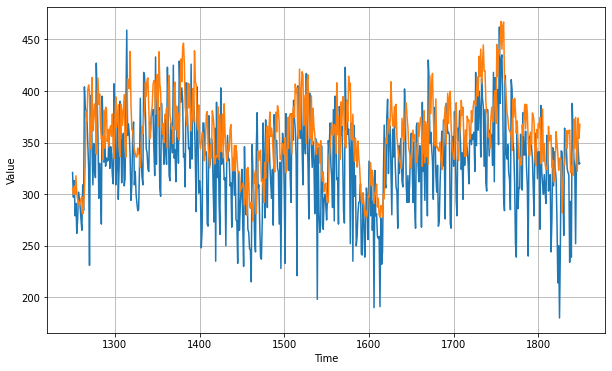

In [63]:
print(time_valid.shape)      
print(x_valid.shape)         
print(rnn_forecast.shape)    
plt.figure(figsize=(10, 6))
title = str("Forecasting with LSTM")
plot_series(time_valid, x_valid * m) # 2-D
plot_series(time_valid, rnn_forecast * m) # we only took the last part of the rnn_forecast

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy() # CNN LSTM 1.77

0.32199696